In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_data = session.query(Measurement).order_by(Measurement.date.desc()).first()
recent_data.date

'2017-08-23'

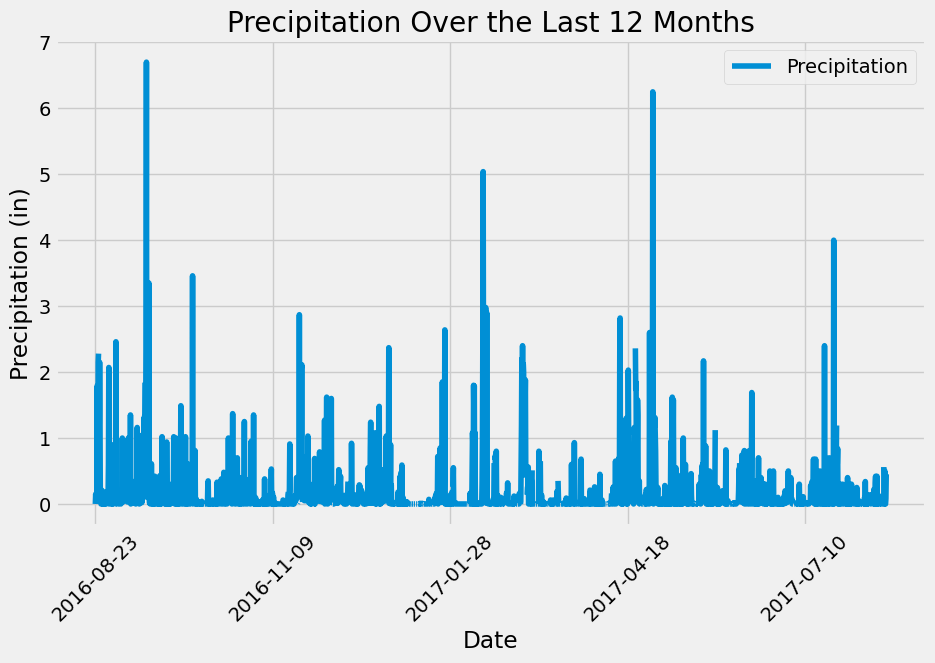

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Convert the recent date string to a datetime object
recent_date = dt.datetime.strptime(recent_data.date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data)

# Sort the dataframe by date
precip_df.sort_values(by='date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x='date', y='prcp', figsize=(10,6), rot=45)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.legend(["Precipitation"], loc='upper right')
plt.grid(True)
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_summary = precip_df['prcp'].describe()
precip_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_num = session.query(Station).order_by(Station.station).count()
station_num

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_active = session.query(Station.station, func.count(Measurement.station)).\
                                join(Measurement, Measurement.station == Station.station).\
                                group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [15]:
recent_data2 = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()
recent_date2 = dt.datetime.strptime(recent_data2.date, '%Y-%m-%d').date()
year_ago2 = recent_date2 - dt.timedelta(days=365)

temp_data = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
                        filter((Measurement.station == 'USC00519281'), (Measurement.date >= year_ago2)).group_by(Measurement.tobs).all()
temp_df = pd.DataFrame(temp_data, columns=['Temperature', 'Frequency'])
temp_df

,Temperature,Frequency
0,59.0,3
1,60.0,2
2,61.0,1
3,62.0,6
4,63.0,4
5,64.0,3
6,65.0,7
7,66.0,5
8,67.0,15
9,68.0,12


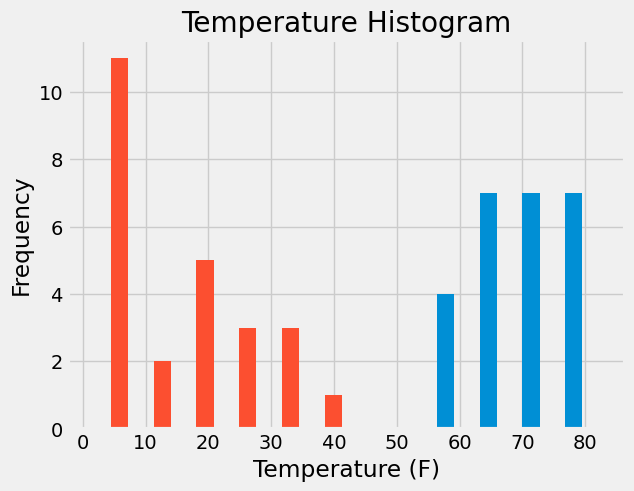

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(temp_df,  bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Histogram')
plt.grid(True)
plt.show()

# Close Session

In [17]:
# Close Session
session.close()